In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Data Collecting and Preprocessing

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url)
df = table[0]
df['Symbol'] = df['Symbol'].str.replace('.', '-')
tickers = df['Symbol'].tolist()

import yfinance as yf
from datetime import datetime, timedelta

start_date = "2020-01-30"
end_date = datetime.now().strftime('%Y-%m-%d')

stock_data = {}
for company in tickers:
    data = yf.download(company, start=start_date, end=end_date, progress=False)
    stock_data[company] = data[['Adj Close', 'Volume']]

# Stock Forecasting

## LSTM

To prevent from long training time, I set the model to be simple.

In [3]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [4]:
AOS = stock_data['AOS']

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [21]:
def train_model(module, record, input_dim, hidden_dim, num_layers, output_dim,
                x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler=None):
    model = module(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    hist = np.zeros(num_epochs)
    start_time = time.time()

    for t in range(0, num_epochs):
        y_train_pred = model(x_train_tensor)
        loss = criterion(y_train_pred, y_train_tensor)
        if num_epochs <= 50:
            if t % 10 == 0:
                print("Epoch ", t, "MSE: ", loss.item())
        else:
            if t % 20 == 0:
                print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))

    if scaler is not None:
        y_train_pred_2d = y_train_pred.detach().numpy().reshape(-1, 1)
        y_train_pred = scaler.inverse_transform(y_train_pred_2d)
        y_train_ori_2d = y_train_tensor.detach().numpy().reshape(-1, 1)
        y_train_ori = scaler.inverse_transform(y_train_ori_2d)

    else:
        y_train_pred = y_train_pred.detach().numpy()
        y_train_ori = y_train_tensor.detach().numpy()

    train_compare = pd.DataFrame({'original':y_train_ori.flatten(), 'predict':y_train_pred.flatten()})

    sns.set_style("darkgrid")    

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 3, 1)
    ax = sns.lineplot(x = train_compare.index, y = train_compare.original, label="Actual Value", color='royalblue')
    ax = sns.lineplot(x = train_compare.index, y = train_compare.predict, label="Training Prediction", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Price (USD)", size = 14)
    _ = ax.set_xticklabels('', size=10)


    plt.subplot(1, 3, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

    y_test_pred = model(x_test_tensor)
    if scaler is not None:
        y_test_pred_2d = y_test_pred.detach().numpy().reshape(-1, 1)
        y_test_ori_2d = y_test_tensor.detach().numpy().reshape(-1, 1)
        y_test_pred = scaler.inverse_transform(y_test_pred_2d)
        y_test_ori = scaler.inverse_transform(y_test_ori_2d)
    else:
        y_test_pred = y_test_pred.detach().numpy()
        y_test_ori = y_test_tensor.detach().numpy()

    trainScore = math.sqrt(mean_squared_error(y_train_ori, y_train_pred))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test_ori, y_test_pred))
    print('Test Score: %.2f RMSE' % (testScore))
    
    record.append(trainScore)
    record.append(testScore)
    record.append(training_time)

    test_compare = pd.DataFrame({'original':y_test_ori.flatten(), 'predict':y_test_pred.flatten()})

    plt.subplot(1, 3, 3)
    ax = sns.lineplot(x = test_compare.index, y = test_compare.original, label="Actual Value", color='royalblue')
    ax = sns.lineplot(x = test_compare.index, y = test_compare.predict, label="Test Prediction", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Price (USD)", size = 14)
    _ = ax.set_xticklabels('', size=10)

    last_prediction = y_test_pred
    actual = y_test_ori

    return model, last_prediction, actual

In [6]:
from sklearn.preprocessing import MinMaxScaler

price = AOS[['Adj Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Adj Close'] = scaler.fit_transform(price['Adj Close'].values.reshape(-1,1))

In [7]:
import torch
import torch.nn as nn

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)

y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((762, 19, 1), (762, 1), (190, 19, 1), (190, 1))

In [9]:
import time
import seaborn as sns

import math
from sklearn.metrics import mean_squared_error

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

Epoch  0 MSE:  0.18084752559661865
Epoch  10 MSE:  0.041929345577955246
Epoch  20 MSE:  0.01917201280593872
Epoch  30 MSE:  0.008139003068208694
Epoch  40 MSE:  0.007839815691113472
Training time: 1.0693414211273193
Train Score: 1.90 RMSE
Test Score: 1.56 RMSE


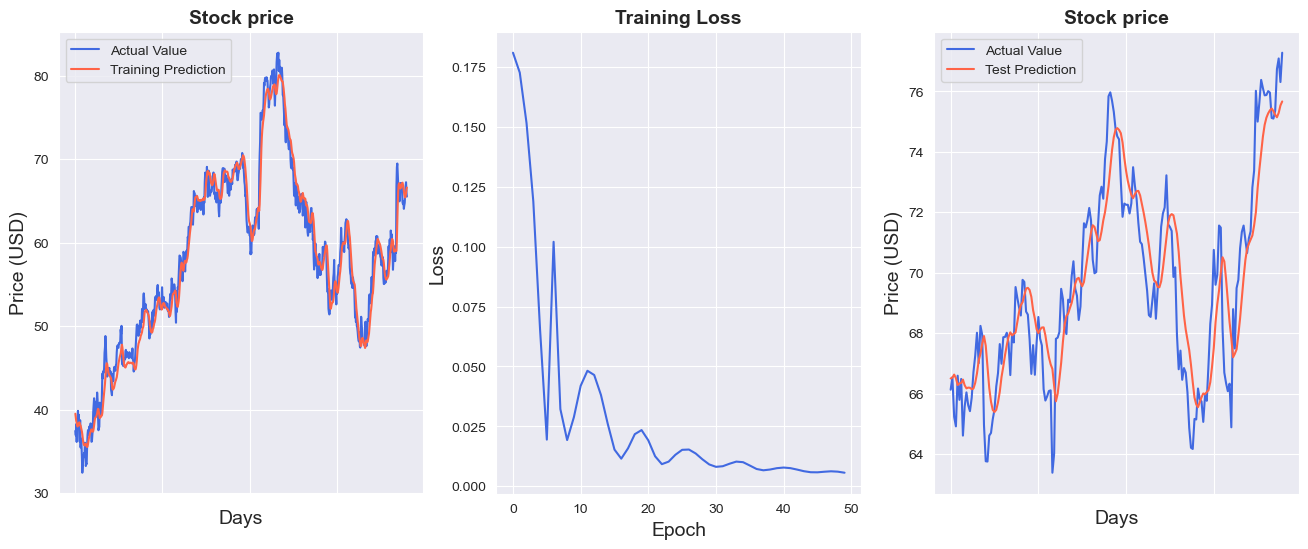

In [13]:
lstm = []
kwargs = dict(input_dim=input_dim, record=lstm, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,
              x_train_tensor=x_train_tensor, x_test_tensor=x_test_tensor, y_train_tensor=y_train_tensor, y_test_tensor=y_test_tensor, scaler=scaler)
lstm_model = train_model(LSTM, **kwargs)

## GRU

In [14]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

Epoch  0 MSE:  0.17313699424266815
Epoch  10 MSE:  0.020847750827670097
Epoch  20 MSE:  0.0041867815889418125
Epoch  30 MSE:  0.004400429781526327
Epoch  40 MSE:  0.0025636705104261637
Training time: 2.8668906688690186
Train Score: 1.29 RMSE
Test Score: 1.11 RMSE


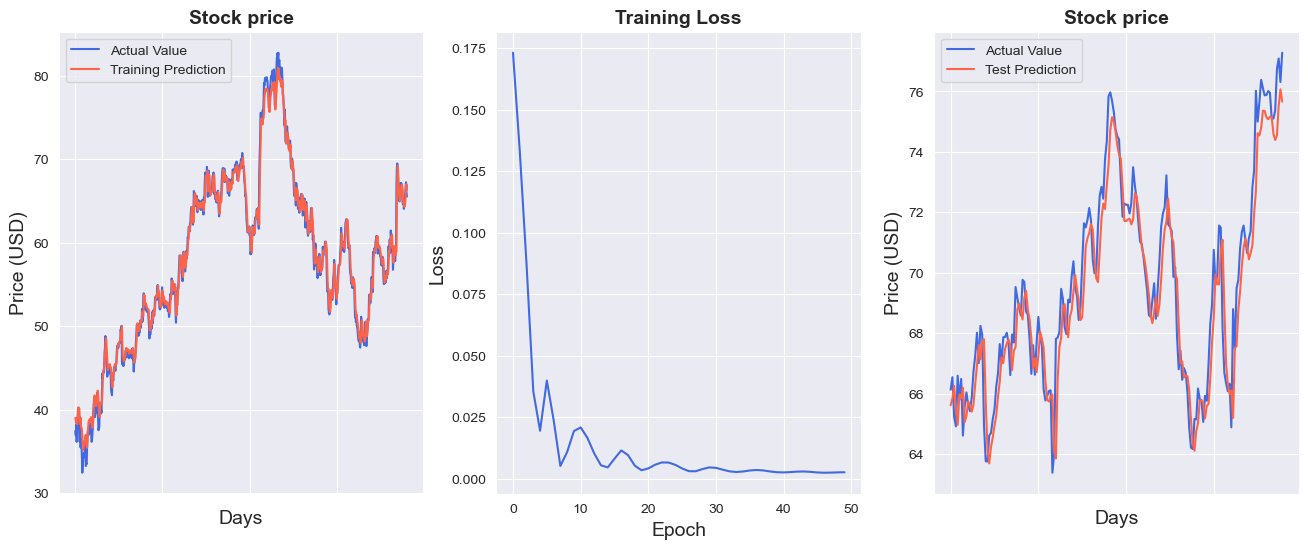

In [22]:
gru = []
kwargs = dict(input_dim=input_dim, record=gru, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,
              x_train_tensor=x_train_tensor, x_test_tensor=x_test_tensor, y_train_tensor=y_train_tensor, y_test_tensor=y_test_tensor, scaler=scaler)
gru_model, last_pred, actual = train_model(GRU, **kwargs)

In [16]:
# trainScore, testScore, training_time
lstm, gru

([1.8966530784741444, 1.5632487219801143, 1.0693414211273193],
 [1.295969221629727, 1.1072305180964632, 2.930695056915283])